In [1]:
from analysis.analyze_results import *
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from collections import defaultdict

In [ ]:
# output_base_folder = Path("/home/ivan/Documents/git/storage-benchmarking/src/benchmark_output")
output_base_folder = Path("/iarai/home/ivan.svogor/git/storage-benchmarking/src/benchmark_output")

In [24]:
s3_folder_filter="1011/*benchmark_e2e*"

In [25]:
def extract_timelines(output_base_folder: Path, folder_filter: str = "**", filter_by_metadata: Dict[str, List[str]] = None,
):
    files = list(output_base_folder.rglob(f"{folder_filter}/timeline-*.log"))
    data = []
    for working_file_path in tqdm.tqdm(files, total=len(files)):
        results = parse_results_log(working_file_path)
        if len(results) == 0:
            continue
        results = pd.DataFrame.from_records(data=results)
        results = pd.merge(results[results["end_time"].isnull()], 
                           results[results["start_time"].isnull()], 
                           left_on='id', 
                           right_on='id').drop(['end_time_x', 'start_time_y'], axis=1)
        results["source_file"] = working_file_path
        results["run"] = working_file_path.parent.name
        # filter out old data format missing dataset etc.
        data.append(results)
    df = pd.concat(data)
    df.groupby
    return df


In [26]:
def show_timelines(df, run, flat=False):
    fig, ax = plt.subplots(figsize=(15, 5))
    # fig, ax = plt.subplots()
    data = defaultdict(list)
    start = min(df["start_time_x"]) 
    i = 0
    for index, row in df.iterrows():
        duration = row["end_time_y"] - row["start_time_x"] 
        x1 = row["start_time_x"] - start 
        if duration < 0.08:
            duration = 0.1
        x2 = x1 + duration
        if not flat:
            lane = i
            i += 2
        else:
            lane = lanes[row["item_x"]]
        ax.plot([x1, x2], [lane, lane], color=colors[row["item_x"]], label=row["item_x"], linewidth=4)
    ax.set_xlabel("Experiment duration", loc="center")
    ax.set_ylabel("Item", loc="top")
    # print(run.split('_'))
    # ['20211109f152412', 'benchmark', 'e2e', 'lightning', 's3', '256', '4', '16', '1', 'vanilla', 'sync']
    filename = run.split('_')
    ax.set_title(f"Runtime for each function, impl: {filename[9]},"
                 f" cache: {filename[8]}, "
                 f" batch size: {filename[5]}, "
                 f" lib: {filename[3]}",
                 loc='center')
    ax.legend()
    ax.grid(linestyle='--', which="both")

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))

    # Put a legend below current axis
    ax.legend(by_label.values(), by_label.keys(), 
              loc='upper center', bbox_to_anchor=(0.5, -0.05),
              fancybox=True, shadow=True, ncol=5)
    plt.show()


In [27]:
df_dataloader = extract_timelines(output_base_folder, folder_filter=s3_folder_filter)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 16.63it/s]


In [28]:
df_dataloader.sort_values(["start_time_x"], ascending=False)

,item_x,id,start_time_x,item_y,end_time_y,source_file,run
59,run_training_batch,9.000276e+18,1.636532e+09,run_training_batch,1.636532e+09,/iarai/home/ivan.svogor/git/storage-benchmarki...,20211110f090416_benchmark_e2e_lightning_s3_256...
58,next_data,2.900000e+01,1.636532e+09,next_data,1.636532e+09,/iarai/home/ivan.svogor/git/storage-benchmarki...,20211110f090416_benchmark_e2e_lightning_s3_256...
57,run_training_batch,-6.102560e+18,1.636532e+09,run_training_batch,1.636532e+09,/iarai/home/ivan.svogor/git/storage-benchmarki...,20211110f090416_benchmark_e2e_lightning_s3_256...
56,next_data,2.800000e+01,1.636532e+09,next_data,1.636532e+09,/iarai/home/ivan.svogor/git/storage-benchmarki...,20211110f090416_benchmark_e2e_lightning_s3_256...
55,run_training_batch,-2.194618e+18,1.636532e+09,run_training_batch,1.636532e+09,/iarai/home/ivan.svogor/git/storage-benchmarki...,20211110f090416_benchmark_e2e_lightning_s3_256...
...,...,...,...,...,...,...,...
4,batch,6.105241e+17,1.636530e+09,batch,1.636530e+09,/iarai/home/ivan.svogor/git/storage-benchmarki...,20211110f083933_benchmark_e2e_torch_s3_256_4_1...
3,batch,-4.167455e+18,1.636530e+09,batch,1.636530e+09,/iarai/home/ivan.svogor/git/storage-benchmarki...,20211110f083933_benchmark_e2e_torch_s3_256_4_1...
2,batch,-1.805480e+17,1.636530e+09,batch,1.636530e+09,/iarai/home/ivan.svogor/git/storage-benchmarki...,20211110f083933_benchmark_e2e_torch_s3_256_4_1...
1,batch,3.388526e+18,1.636530e+09,batch,1.636530e+09,/iarai/home/ivan.svogor/git/storage-benchmarki...,20211110f083933_benchmark_e2e_torch_s3_256_4_1...


In [29]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999

<IPython.core.display.Javascript object>

In [ ]:
unique_functions = np.unique(df_dataloader["item_x"])
print(f"Unique functions: {unique_functions}")
for i, color in zip(unique_functions, ["red", "gold", "blue", "magenta", "aqua"]):
    colors[str(i)] = color
lanes={}
for i, lane in zip(unique_functions, range(len(unique_functions))):
    lanes[str(i)] = lane
    
df_dataloader = extract_timelines(output_base_folder, folder_filter=s3_folder_filter)
df_dataloader.sort_values(["start_time_x"], ascending=False)
unique_runs = np.unique(df_dataloader["run"])


for implementation in ["torch", "lightning"]:
    for run in unique_runs:
        if implementation in run:
            df = df_dataloader[df_dataloader["run"]==run]
            show_timelines(df, run, False)

In [31]:
def extract_gpuutil(output_base_folder: Path, folder_filter: str = "**", filter_by_metadata: Dict[str, List[str]] = None,
):
    files = list(output_base_folder.rglob(f"{folder_filter}/gpuutil-*.log"))
    data = []
    for working_file_path in tqdm.tqdm(files, total=len(files)):
        results = parse_results_log(working_file_path)
        if len(results) == 0:
            continue
        header = []
        header.append("timestamp")
        for i in results[0]["gpu_data"]:
            header.append(f"gpu_{i}")
        header.append("run")
        lines = []
        for result in results:
            line = []
            line.append(result["timestamp"])
            for item in result["gpu_data"]:
                line.append(result["gpu_data"][item]["gpu_util"])
            line.append(working_file_path.parent.name)
            lines.append(line)
        results = pd.DataFrame.from_records(lines)
        data.append(results)
    df = pd.concat(data)
    df.columns = header
    df.groupby
    df.sort_values(["timestamp"], ascending=True)
    return df

In [32]:
df_gpuutil = extract_gpuutil(output_base_folder, folder_filter=s3_folder_filter)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 18.18it/s]


In [34]:
df_gpuutil

,timestamp,gpu_0,gpu_1,gpu_2,gpu_3,run
0,1.636530e+09,0.0,0.0,0.0,0.0,20211110f083933_benchmark_e2e_torch_s3_256_4_1...
1,1.636530e+09,0.0,0.0,0.0,0.0,20211110f083933_benchmark_e2e_torch_s3_256_4_1...
2,1.636530e+09,0.0,0.0,0.0,0.0,20211110f083933_benchmark_e2e_torch_s3_256_4_1...
3,1.636530e+09,0.0,0.0,0.0,0.0,20211110f083933_benchmark_e2e_torch_s3_256_4_1...
4,1.636530e+09,0.0,0.0,0.0,0.0,20211110f083933_benchmark_e2e_torch_s3_256_4_1...
...,...,...,...,...,...,...
186,1.636532e+09,0.0,0.0,95.0,0.0,20211110f090416_benchmark_e2e_lightning_s3_256...
187,1.636532e+09,0.0,0.0,8.0,0.0,20211110f090416_benchmark_e2e_lightning_s3_256...
188,1.636532e+09,0.0,0.0,0.0,0.0,20211110f090416_benchmark_e2e_lightning_s3_256...
189,1.636532e+09,0.0,0.0,5.0,0.0,20211110f090416_benchmark_e2e_lightning_s3_256...


In [51]:
unique_runs = np.unique(df_dataloader["run"])

In [57]:
 def show_timelines(df, gpu_util, run, flat=False, show_gpu=False):
    fig, ax = plt.subplots(figsize=(15, 5))
    # fig, ax = plt.subplots()
    data = defaultdict(list)
    start = min(df["start_time_x"]) 
    gpu_start = min(gpu_util["timestamp"])
    for index, row in df.iterrows():
        duration = row["end_time_y"] - row["start_time_x"] 
        x1 = row["start_time_x"] - start 
        if duration < 0.15:
            duration = 0.2
        x2 = x1 + duration
        if not flat:
            lane = index
        else:
            lane = lanes[row["item_x"]]
        ax.plot([x1, x2], [lane, lane], color=colors[row["item_x"]], label=row["item_x"], linewidth=4)
    

    ax.set_xlabel("Experiment duration", loc="right")
    ax.set_ylabel("Item", loc="top")
    filename = run.split('_')
    ax.set_title(f"Runtime for each function, impl: {filename[9]},"
                 f" cache: {filename[8]}, "
                 f" batch size: {filename[5]}, "
                 f" lib: {filename[3]}",
                 loc='center')
    
    ax.legend()
    ax.grid(linestyle='--', which="both")

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))

    # Put a legend below current axis
    ax.legend(by_label.values(), by_label.keys(), 
              loc='upper center', bbox_to_anchor=(0.5, -0.05),
              fancybox=True, shadow=True, ncol=5)
    
    if show_gpu:
        ax2 = ax.twinx() 
        ax2.set_ylabel('GPU Util', color="cyan") 
        gpu_events = []
        for i in gpu_util["timestamp"]:
            gpu_events.append(i - start)
        ax2.plot(gpu_events, gpu_util["gpu_2"], color="cyan", linestyle="--", linewidth=1)

    plt.show()

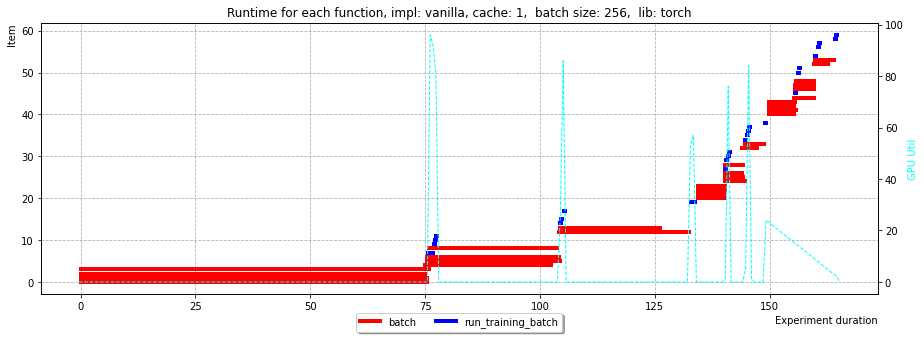

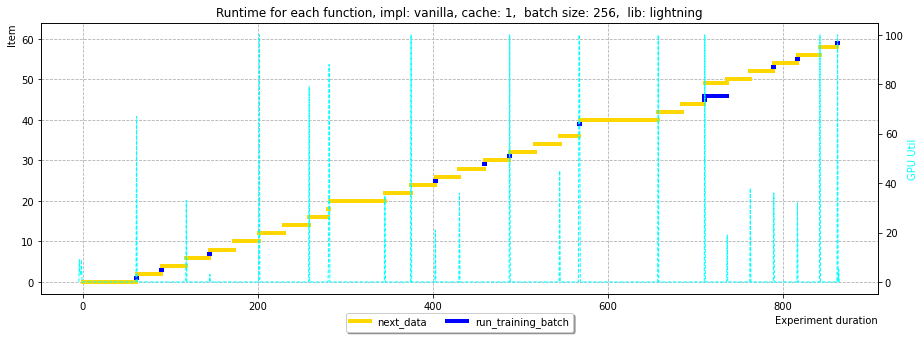

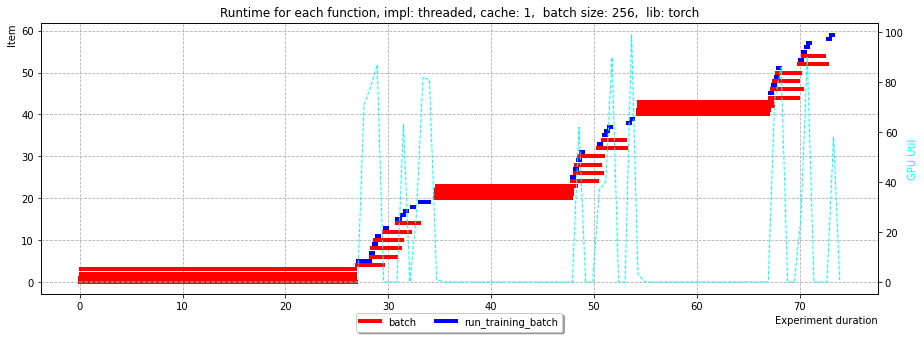

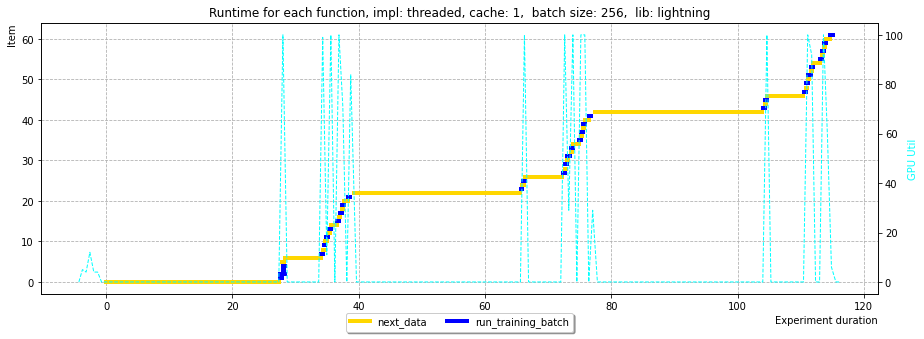

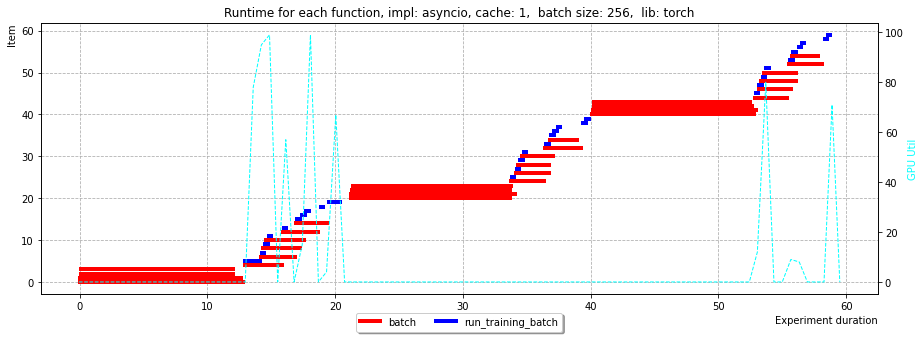

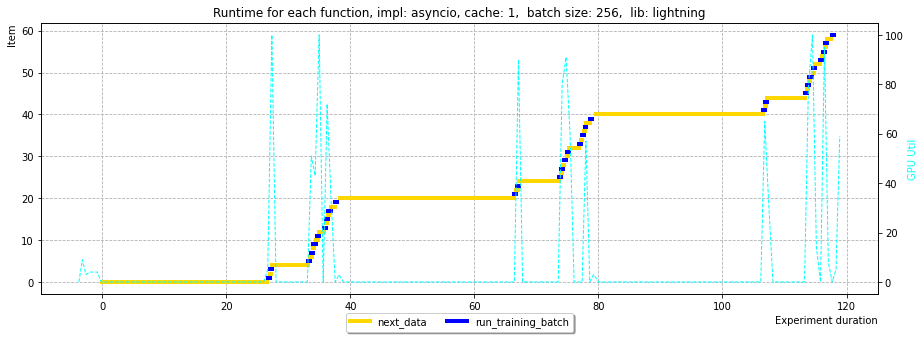

In [58]:
 for run in unique_runs:
    df = df_dataloader[df_dataloader["run"]==run]
    dfgpu = df_gpuutil[df_gpuutil["run"]==run]
    show_timelines(df, dfgpu, run, False, True)